In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn
import os
import sys
import importlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
sys.path.append('../../model/')
import importlib
import modelAdjustments
from modelAdjustments import Combined_Dataset, train, test, categorize_columns 
import time

In [3]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

device_in_use='cpu'

df_train = pd.read_csv('../../datasets/higgs/train.csv')
df_test = pd.read_csv('../../datasets/higgs/test.csv')
df_val = pd.read_csv('../../datasets/higgs/validation.csv') #READ FROM RIGHT SPOT

target = 'class'
cat_columns, cont_columns, unique_classes_per_column = categorize_columns(df_train, target)

if target in cont_columns:
    print("Warning: CONT ")
    cont_columns.remove(target)
elif target in cat_columns:
    print("Warning: CAT ")
    cat_columns.remove(target)

print("Target:", target)
print("Categorical: ", cat_columns, len(cat_columns))
print("Continous: ", cont_columns, len(cont_columns))
print("Unique Classes per Column: ", unique_classes_per_column)

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cat_columns + cont_columns + [target]
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print('target classes: ', target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

# label encode target...
le = LabelEncoder()
df_train[target] = le.fit_transform(df_train[target])
df_test[target] = le.fit_transform(df_test[target])
df_val[target] = le.fit_transform(df_val[target])

# ...and categorical features
for feature in cat_columns:
    # print(feature)
    df_train[feature] = le.fit_transform(df_train[feature])
    df_test[feature] = le.fit_transform(df_test[feature])
    df_val[feature] = le.fit_transform(df_val[feature])


#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns, cont_columns, target)
val_dataset = Combined_Dataset(df_val, cat_columns, cont_columns, target)
test_dataset = Combined_Dataset(df_test, cat_columns, cont_columns, target)

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

GPU is not available, using CPU instead
Target: class
Categorical:  ['jet1b-tag', 'jet2b-tag', 'jet3b-tag', 'jet4b-tag'] 4
Continous:  ['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta', 'jet1phi', 'jet2pt', 'jet2eta', 'jet2phi', 'jet3pt', 'jet3eta', 'jet3phi', 'jet4pt', 'jet4eta', 'jet4phi', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'] 24
Unique Classes per Column:  [3, 3, 3, 3]
target classes:  [2]


In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x, self.avg_attention 

class ExpFF(nn.Module):
    def __init__(self, alpha, embed_size, n_cont, cat_feat, num_target_labels):
        super(ExpFF, self).__init__()

        self.alpha = alpha
        self.embed_size = embed_size
        self.n_cont = n_cont
        self.cat_feat_on = False
        if len(cat_feat)!=0:
            self.cat_feat_on=True
        else:
            self.cat_feat_on = False

        coefficients = self.alpha ** (torch.arange(self.embed_size//2) / self.embed_size//2) #Each feature shares the same set of scaling factors
        coefficients = coefficients.unsqueeze(0)

        self.register_buffer('embedding_coefficients', coefficients)

        self.lin_embed = nn.ModuleList([nn.Linear(in_features=self.embed_size, out_features=self.embed_size) for _ in range(n_cont)]) # each feature gets its own linear layer

        if self.cat_feat_on:
            self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])
            
        #CLS Token
        self.target_label_embed = nn.ModuleList([nn.Embedding(1, self.embed_size) for _ in range(num_target_labels)])

    def forward(self, x_cat, x_cont):
        x = x_cont.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)

        temp = []
        for i in range(self.n_cont):
            input = x[:,i,:]
            # print('x: ', x.shape)
            #(1,80)x(256,1)
            out = torch.cat([torch.cos(2* torch.pi * self.embedding_coefficients * input), torch.sin(2 * torch.pi * self.embedding_coefficients * input)], dim=-1)
            temp.append(out)
        
        embeddings = []
        x = torch.stack(temp, dim=1)
        for i, e in enumerate(self.lin_embed):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        if self.cat_feat_on:
            cat_x = x_cat.unsqueeze(2)
            for i, e in enumerate(self.cat_embeddings):
                goin_in = cat_x[:,i,:]
                goin_out = e(goin_in)
                goin_out=goin_out.squeeze(1)
                embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embed:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class ClassificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(ClassificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class RegressionHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification):
        super(RegressionHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, 1)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class CATTransformer(nn.Module):
    def __init__(self, 
                 alpha=0.5, # Used to initialize the coefficients for the Exponential FF 
                 embed_size=160,
                 n_cont = 0,
                 cat_feat:list = [], # ex: [10,4] - 10 categories in the first column, 4 categories in the second column
                 num_layers=1, #Transformer layers
                 heads=5, 
                 forward_expansion=8, # Determines how wide the Linear Layers are the encoder. Its a scaling factor. 
                 decoder_dropout=0.1,
                 classification_dropout = 0.1,
                 pre_norm_on = False,
                 mlp_scale_classification = 8, #Scaling factor for linear layers in head
                 regression_on = False,
                 targets_classes : list=  [3]
                 ):
        super(CATTransformer, self).__init__()

        self.regression_on = regression_on

        self.embeddings = ExpFF(alpha=alpha, embed_size=embed_size, n_cont=n_cont, cat_feat=cat_feat,
                                num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        if not regression_on:
            self.out_head = ClassificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=targets_classes[0])
        else:
            self.out_head = RegressionHead(embed_size=embed_size, dropout=classification_dropout, mlp_scale_classification=mlp_scale_classification)

    def forward(self, cat_x, cont_x):
        class_embed, context = self.embeddings(cat_x, cont_x)

        x, avg_attention = self.decoder(class_embed, context)
        
        # for i, e in enumerate(self.heads):
        #     input = x[:, i,:]
        #     output = e(input)
           
        output = self.out_head(x)

        return output, avg_attention


# Dataset loaders for different cases
class Cont_Dataset(Dataset):
    def __init__(self, df : pd.DataFrame, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.int64).values

        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return num_features, labels_task1
    
class Cat_Cont_Dataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1
    
class Combined_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, cat_columns, num_columns, task1_column):
        self.n = df.shape[0]

        self.task1_labels = df[task1_column].astype(np.float32).values

        # If categorical columns exist, load them; otherwise, initialize as an empty tensor
        if len(cat_columns) > 0:
            self.cate = df[cat_columns].astype(np.int64).values
        else:
            self.cate = torch.empty((self.n, 0))  # Empty tensor when no categorical features

        self.num = df[num_columns].astype(np.float32).values

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1
    
def rmse(y_true, y_pred):
    # Calculate the squared differences
    squared_diff = (y_true - y_pred)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff)

    # Calculate the square root to obtain RMSE
    rmse = torch.sqrt(mean_squared_diff)

    return rmse.item()  # Convert to a Python float

#Training and Testing Loops for Different Cases
def train(regression_on, dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss=0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_rmse = 0

    if not regression_on:
        for (cat_x, cont_x, labels) in dataloader:
            cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)
            # print(cont_x.shape)

            predictions, attention = model(cat_x, cont_x)

            loss = loss_function(predictions, labels.long())
            total_loss+=loss.item()

            #computing accuracy
            y_pred_softmax_1 = torch.softmax(predictions, dim=1)
            _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
            total_correct_1 += (y_pred_labels_1 == labels).sum().item()
            total_samples_1 += labels.size(0)
            all_targets_1.extend(labels.cpu().numpy())
            all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss/len(dataloader)
        accuracy = total_correct_1 / total_samples_1

        return avg_loss, accuracy, attention
    
    else:
        for (cat_x, cont_x, labels) in dataloader:
            cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)

            predictions, attention = model(cat_x, cont_x)

            loss = loss_function(predictions, labels.unsqueeze(1))
            total_loss+=loss.item()

            rmse_value = rmse(labels.unsqueeze(1), predictions)
            total_rmse+=rmse_value

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss/len(dataloader)
        avg_rmse = total_rmse/len(dataloader)

        return avg_loss, avg_rmse, attention

def test(regression_on, dataloader, model, loss_function, device_in_use):
    model.eval()

    total_loss=0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_rmse = 0

    if not regression_on:
        with torch.no_grad():
            for (cat_x, cont_x, labels) in dataloader:
                cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)
                # print(cont_x.shape)

                predictions, attention = model(cat_x, cont_x)

                loss = loss_function(predictions, labels.long())
                total_loss+=loss.item()

                #computing accuracy
                y_pred_softmax_1 = torch.softmax(predictions, dim=1)
                _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
                total_correct_1 += (y_pred_labels_1 == labels).sum().item()
                total_samples_1 += labels.size(0)
                all_targets_1.extend(labels.cpu().numpy())
                all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

            avg_loss = total_loss/len(dataloader)
            accuracy = total_correct_1 / total_samples_1

            return avg_loss, accuracy, attention
    
    else:
        with torch.no_grad():
            for (cat_x, cont_x, labels) in dataloader:
                cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)

                predictions, attention = model(cat_x, cont_x)

                loss = loss_function(predictions, labels.unsqueeze(1))
                total_loss+=loss.item()

                rmse_value = rmse(labels.unsqueeze(1), predictions)
                total_rmse+=rmse_value

            avg_loss = total_loss/len(dataloader)
            avg_rmse = total_rmse/len(dataloader)

            return avg_loss, avg_rmse, attention
        
# helpers 

def categorize_columns(dataframe, target):
    categorical_columns = []
    continuous_columns = []
    unique_classes_per_column = []  # To hold the number of unique classes for each categorical column

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) <= 10:
            # If the column's data type is 'object' or it has 10 or fewer unique values, consider it categorical.
            if column != target:
                categorical_columns.append(column)
                unique_classes_per_column.append(dataframe[column].nunique())  # Store the number of unique classes
        else:
            # Otherwise, consider it continuous.
            continuous_columns.append(column)

    return categorical_columns, continuous_columns, unique_classes_per_column


Epoch [ 1/5]         | Train: Loss 0.6842926696330641, Accuracy 0.552918378646152       
Epoch [ 2/5]         | Train: Loss 0.6688173561734337, Accuracy 0.5822478654894075      
Epoch [ 3/5]         | Train: Loss 0.6678865015728322, Accuracy 0.5831512078561646      
Epoch [ 4/5]         | Train: Loss 0.6654893434623803, Accuracy 0.5865023166360696      
Epoch [ 5/5]         | Train: Loss 0.6618527918500084, Accuracy 0.588906372934697       


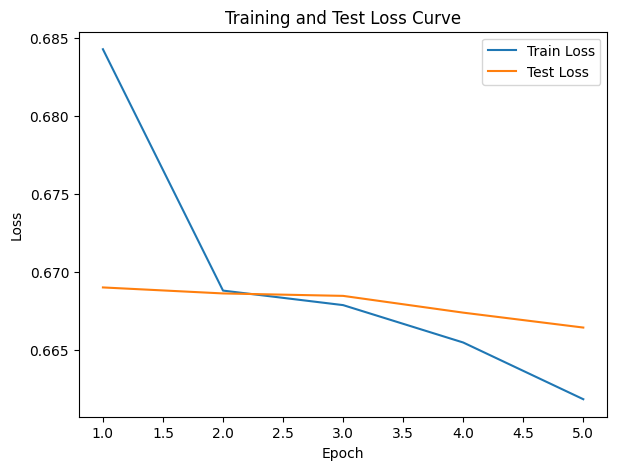

In [5]:
regression_on = False

model = CATTransformer(alpha = 0.5,
                       embed_size=160,
                       n_cont=len(cont_columns),
                       cat_feat=unique_classes_per_column,
                       targets_classes=target_classes,
                       regression_on=regression_on
                       ).to(device_in_use)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 5 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 

train_attentions = []
test_attentions = []

#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
    train_loss, train_acc, attention_train = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    train_attentions.append(attention_train)

    test_loss, test_acc, attention_test = test(regression_on=False, dataloader=test_dataloader, model=model, loss_function=loss_function, device_in_use=device_in_use)
    test_attentions.append(attention_test)

    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)

    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    print(f"{epoch_str:20} | {train_metrics:65}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

In [6]:
attention_test.shape

torch.Size([28])

In [7]:
attention_train

tensor([0.0349, 0.0358, 0.0350, 0.0352, 0.0347, 0.0356, 0.0353, 0.0360, 0.0358,
        0.0361, 0.0356, 0.0354, 0.0361, 0.0356, 0.0355, 0.0356, 0.0355, 0.0317,
        0.0392, 0.0275, 0.0360, 0.0409, 0.0366, 0.0368, 0.0378, 0.0400, 0.0360,
        0.0338], grad_fn=<SqueezeBackward1>)